#### Иморт библиотек для работы всего ноутбука



In [1]:
import numpy as np  # Для работы с данными
import pandas as pd  # Для работы с таблицами
import matplotlib.pyplot as plt  # Для вывода графиков
import os  # Для работы с файлами

#from tensorflow.keras.utils import to_categorical
from tensorflow.keras import utils  # Для работы с категориальными данными
from tensorflow.keras.models import Sequential  # Полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation  # Слои для сети
from tensorflow.keras.preprocessing.text import \
    Tokenizer  # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Метод для работы с последовательностями

from sklearn.preprocessing import LabelEncoder  # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split  # Для разделения выборки на тестовую и обучающую
import time  # Импортируем библиотеку time

### Классификация текстов сайтов

In [2]:
def readText(fileName, a):  # Объявляем функции для чтения файла. На вход отправляем путь к файлу
    f = open(fileName, 'r', encoding=a)  # Задаем открытие нужного файла в режиме чтения
    text = f.read()  # Читаем текст
    text = text.replace("\n", " ")  # Переносы строки переводим в пробелы

    return text  # Возвращаем текст файла


# Объявляем интересующие нас классы
className = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 
             'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 
             'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast']
nClasses = len(className)

In [3]:
# загружаем обучающие тексты

trainText = []  # формируем обучающие тексты
testText = []  # формируем тестовые тексты

for i in os.listdir(r'C:\Users\Mops010\Downloads\dataset1'):  # проходимся по папке dataset
    if 'train' in i:  # проверяем есть ли в имени файла из dataset слово train
        for elem in os.listdir(r'C:\Users\Mops010\Downloads\dataset1\20news-bydate-train'):
            for elem1 in os.listdir(r'C:\Users\Mops010\Downloads\dataset1\20news-bydate-train/' + elem):
                # добавляем в обучающую выборку
                trainText.append(
                    readText(r'C:\Users\Mops010\Downloads\dataset1\20news-bydate-train/' + elem + '/' + elem1, None))

    if 'test' in i:  # проверяем есть ли в имени файла из dataset слово train
        for elem in os.listdir(r'C:\Users\Mops010\Downloads\dataset1\20news-bydate-test'):
            for elem1 in os.listdir(r'C:\Users\Mops010\Downloads\dataset1\20news-bydate-test/' + elem):
                # добавляем в обучающую выборку
                testText.append(
                    readText(r'C:\Users\Mops010\Downloads\dataset1\20news-bydate-test/' + elem + '/' + elem1, None))

#### Обработка данных. Преобразование текстовых данных в числовые и векторные для обчения нейросети

In [4]:
cur_time = time.time()  # Засекаем текущее время
maxWordsCount = 20000  # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - просим токенайзер не удалять однобуквенные слова
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(
    trainText)  # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items())  # Вытаскиваем индексы слов для просмотра
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

Время обработки: 1.46c


In [5]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText)  # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[1][:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[1][:20], '\n')
print(len(trainWordIndexes), len(testWordIndexes))

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               From: lipman@oasys.dt.navy.mil (Robert Lipman) Subject: CALL FOR PRESENTATIONS: Navy Sc
Он же в виде последовательности индексов:  [15, 8937, 4596, 3385, 1515, 1018, 513, 8937, 30, 373, 13, 7541, 1515, 3306, 6391, 8938, 59, 9, 114, 4596] 

17 17


In [6]:
print("Статистика по обучающим текстам:")

symbolsTrainText = 0  # Объявляем переменную для подсчета символов в обучающих текстах
wordsTrainText = 0  # Объявляем переменную для подсчета слов в обучающих текстах

for i in range(nClasses):  # Проходим по всем классам
    print(className[i], " ", len(trainText[i]), "символов, ", len(trainWordIndexes[i]),
          "слов")
    symbolsTrainText += len(trainText[i])  # Считаем символы
    wordsTrainText += len(trainWordIndexes[i])  # Считаем слова

print('----')
print("В сумме ", symbolsTrainText, " символов, ", wordsTrainText, " слов \n")
print()
print("Статистика по тестовым текстам:")

symbolsTestText = 0  # Объявляем переменную для подсчета символов в тестовых текстах
wordsTestText = 0  # Объявляем переменную для подсчета слов в тестовых текстах

for i in range(nClasses):  #Проходим по всем классам
    print(className[i], ' ', len(testText[i]), "символов, ", len(testWordIndexes[i]), "слов")
    symbolsTestText += len(testText[i])  #Считаем символы
    wordsTestText += len(testWordIndexes[i])  #Считаем слова
print('----')
print("В сумме ", symbolsTestText, " символов, ", wordsTestText, " слов")


### Создание обучающей и проверочной выборки
#### Функции для формирования выборки по отрезкам текста с заданным шагом

# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
def getSetFromIndexes(wordIndexes, xLen, step):  # функция принимает последовательность индексов, размер окна, шаг окна
    xSample = []  # Объявляем переменную для векторов
    wordsLen = len(wordIndexes)  # Считаем количество слов
    index = 0  # Задаем начальный индекс

    while index + xLen <= wordsLen:  # Идём по всей длине вектора индексов
        xSample.append(wordIndexes[index:index + xLen])  # "Откусываем" векторы длины xLen
        index += step  # Смещаемся вперёд на step

    return xSample


# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen,
                           step):  # Функция принимает последовательность индексов, размер окна, шаг окна

    # Для каждого из 6 классов
    # Создаём обучающую/проверочную выборку из индексов
    nClasses = len(wordIndexes)  # Задаем количество классов выборки
    classesXSamples = []  # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
    for wI in wordIndexes:  # Для каждого текста выборки из последовательности индексов
        classesXSamples.append(getSetFromIndexes(wI, xLen,
                                                 step))  # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна"

    # Формируем один общий xSamples
    xSamples = []  # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
    ySamples = []  # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"

    for t in range(nClasses):  # В диапазоне кол-ва классов(6)
        xT = classesXSamples[t]  # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
        for i in range(len(xT)):  # И каждое его окно
            xSamples.append(xT[i])  # Добавляем в общий список выборки
            ySamples.append(utils.to_categorical(t, num_classes=nClasses))  # Добавляем соответствующий вектор класса

    xSamples = np.array(xSamples)  # Переводим в массив numpy для подачи в нейронку
    ySamples = np.array(ySamples)  # Переводим в массив numpy для подачи в нейронку

    return xSamples, ySamples  #Функция возвращает выборку и соответствующие векторы классов

Статистика по обучающим текстам:
alt.atheism   1040310 символов,  170983 слов
comp.graphics   909347 символов,  141388 слов
comp.os.ms-windows.misc   1768620 символов,  379599 слов
comp.sys.ibm.pc.hardware   798090 символов,  131217 слов
comp.sys.mac.hardware   694017 символов,  115202 слов
misc.forsale   608874 символов,  92293 слов
rec.autos   858272 символов,  143012 слов
rec.motorcycles   808755 символов,  131479 слов
rec.sport.baseball   848376 символов,  141859 слов
rec.sport.hockey   1187248 символов,  194011 слов
sci.crypt   1500112 символов,  239680 слов
sci.electronics   812524 символов,  131570 слов
sci.med   1192827 символов,  186068 слов
sci.space   1195589 символов,  188424 слов
soc.religion.christian   1355647 символов,  227994 слов
talk.politics.guns   1310831 символов,  213596 слов
talk.politics.mideast   1763573 символов,  287106 слов
----
В сумме  18653012  символов,  3115481  слов 


Статистика по тестовым текстам:
alt.atheism   701644 символов,  113553 слов
comp.gr

#### Подготовка данных

In [10]:
#Задаём базовые параметры
xLen = 500  #Длина отрезка текста, по которой анализируем, в словах
step = 50 #Шаг разбиения исходного текста на обучающие векторы


In [11]:
cur_time = time.time()  # Засекаем текущее время
#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)  #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)  #извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
#получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(62148, 500)
(62148, 17)
(37544, 500)
(37544, 17)
Время обработки: 2.66c


In [12]:
cur_time = time.time()  # Засекаем текущее время
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist())  #Подаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())  # Подаем xTest в виде списка, чтобы метод успешно сработал

print(xTrain01.shape)  # Размер обучающей выборки, сформированной по Bag of Words
print(xTrain01[0][0:100])  # Фрагмент набора слов в виде Bag of Words
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(62148, 20000)
[0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1.
 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1.
 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0.]
Время обработки: 17.59c


### Нейросеть

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               10000500  
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 batch_normalization (BatchN  (None, 500)              2000      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 17)                8517      
                                                                 
Total params: 10,011,017
Trainable params: 10,010,017
Non-trainable params: 1,000
_________________________________________________________________
Epoch 1/10
486/486 [==============================] - 60s 121ms/step - loss: 0.0332 - accuracy: 0.9909 - v

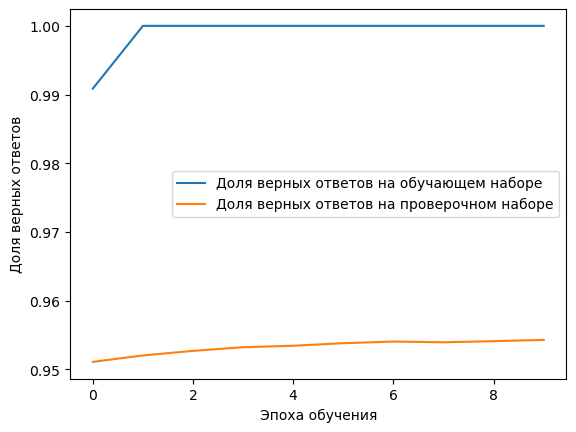

7.3 мин


In [13]:
cur_time = time.time()
#Создаём полносвязную сеть
model01 = Sequential()
#Первый полносвязный слой
model01.add(Dense(500, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.20))
#Слой пакетной нормализации
model01.add(BatchNormalization())
#Выходной полносвязный слой
model01.add(Dense(17, activation='softmax'))

model01.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model01.summary()

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01,
                      yTrain,
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()
print(f'{round(int(time.time() - cur_time) / 60, 2)} мин')

In [14]:
model01.save('model01')

INFO:tensorflow:Assets written to: model01\assets


INFO:tensorflow:Assets written to: model01\assets


In [15]:
from tensorflow import keras

model = keras.models.load_model('model01')

#### Распознавание проверочной выборки

In [11]:
# Представляем тестовую выборку в удобных для распознавания размерах
def createTestMultiClasses(wordIndexes, xLen,
                           step):  #функция принимает последовательность индексов, размер окна, шаг окна

    #Для каждого из 6 классов
    #Создаём тестовую выборку из индексов
    nClasses = len(wordIndexes)  #Задаем количество классов
    xTest6Classes01 = []  #Здесь будет список из всех классов, каждый размером "кол-во окон в тексте * 20000 (при maxWordsCount=20000)"
    xTest6Classes = []  #Здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(6 по 420*1000)
    for wI in wordIndexes:  #Для каждого тестового текста из последовательности индексов
        sample = (
            getSetFromIndexes(wI, xLen, step))  #Тестовая выборка размером "кол-во окон*длину окна"(например, 420*1000)
        xTest6Classes.append(sample)  # Добавляем в список
        xTest6Classes01.append(tokenizer.sequences_to_matrix(
            sample))  #Трансформируется в Bag of Words в виде "кол-во окон в тексте * 20000"
    xTest6Classes01 = np.array(xTest6Classes01)  #И добавляется к нашему списку,
    xTest6Classes = np.array(xTest6Classes)  #И добавляется к нашему списку,

    return xTest6Classes01, xTest6Classes  #функция вернёт тестовые данные: TestBag 6 классов на n*20000 и xTestEm 6 по n*1000


# Распознаём тестовую выборку и выводим результаты
def recognizeMultiClass(model, xTest, modelName):
    print("НЕЙРОНКА: ", modelName)
    print()

    totalSumRec = 0  # Сумма всех правильных ответов

    #Проходим по всем классам
    for i in range(nClasses):
        #Получаем результаты распознавания класса по блокам слов длины xLen
        currPred = model.predict(xTest[i])
        #Определяем номер распознанного класса для каждого блока слов длины xLen
        currOut = np.argmax(currPred, axis=1)

        evVal = []
        for j in range(nClasses):
            evVal.append(len(currOut[currOut == j]) / len(xTest[i]))

        totalSumRec += len(currOut[currOut == i])
        recognizedClass = np.argmax(evVal)  #Определяем, какой класс в итоге за какой был распознан

        #Выводим результаты распознавания по текущему классу
        isRecognized = " Это НЕПРАВИЛЬНЫЙ ответ!"
        if recognizedClass == i:
            isRecognized = " Это ПРАВИЛЬНЫЙ ответ!"
        str1 = 'Класс: ' + className[i] + " " + str(int(100 * evVal[i])) + "% сеть отнесла к классу " + className[
            recognizedClass]
        print(str1, " " * (55 - len(str1)), isRecognized, sep='')

    #Выводим средний процент распознавания по всем классам вместе
    print()
    sumCount = 0
    for i in range(nClasses):
        sumCount += len(xTest[i])
    print("Средний процент распознавания ", int(100 * totalSumRec / sumCount), "%", sep='')

    print()

    return totalSumRec / sumCount

In [12]:
xTest6Classes01, x2 = createTestMultiClasses(testWordIndexes, xLen, step)  #Преобразование тестовой выборки

C:\Users\Mops010\AppData\Local\Temp\ipykernel_13080\3752828187.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xTest6Classes01 = np.array(xTest6Classes01)  #И добавляется к нашему списку,
C:\Users\Mops010\AppData\Local\Temp\ipykernel_13080\3752828187.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xTest6Classes = np.array(xTest6Classes)  #И добавляется к нашему списку,


In [13]:
#Проверяем точность нейронки обученной на bag of words
pred = recognizeMultiClass(model01, xTest6Classes01, "Тексты 01 + Dense")

НЕЙРОНКА:  Тексты 01 + Dense

71/71 [==============================] - 0s 5ms/step
Класс: alt.atheism 87% сеть отнесла к классу alt.atheism Это ПРАВИЛЬНЫЙ ответ!
84/84 [==============================] - 0s 5ms/step
Класс: comp.graphics 93% сеть отнесла к классу comp.graphics Это ПРАВИЛЬНЫЙ ответ!
80/80 [==============================] - 0s 5ms/step
Класс: comp.os.ms-windows.misc 89% сеть отнесла к классу comp.os.ms-windows.misc Это ПРАВИЛЬНЫЙ ответ!
50/50 [==============================] - 0s 5ms/step
Класс: comp.sys.ibm.pc.hardware 90% сеть отнесла к классу comp.sys.ibm.pc.hardware Это ПРАВИЛЬНЫЙ ответ!
48/48 [==============================] - 0s 5ms/step
Класс: comp.sys.mac.hardware 90% сеть отнесла к классу comp.sys.mac.hardware Это ПРАВИЛЬНЫЙ ответ!
41/41 [==============================] - 0s 5ms/step
Класс: misc.forsale 96% сеть отнесла к классу misc.forsale Это ПРАВИЛЬНЫЙ ответ!
56/56 [==============================] - 0s 5ms/step
Класс: rec.autos 99% сеть отнесла к классу rec.au

### Считывание и обработка введённой URL ссылки

In [18]:
url_to_text = [readText(r'C:\Users\Mops010\Downloads\test_sci_cript.txt', 'utf-8')]

urlWordIndexes = tokenizer.texts_to_sequences(url_to_text)  #  тесты в индексы

In [19]:
def getSetFromIndexes1(wordIndexes, xLen, step):  # функция принимает последовательность индексов, размер окна, шаг окна
    xSample = []  # Объявляем переменную для векторов
    wordsLen = len(wordIndexes)  # Считаем количество слов
    index = 0  # Задаем начальный индекс

    while index + xLen <= wordsLen:  # Идём по всей длине вектора индексов
        xSample += wordIndexes[index:index + xLen]  # "Откусываем" векторы длины xLen
        index += step  # Смещаемся вперёд на step

    return xSample

In [20]:
def createSetsMultiClasses(wordIndexes, xLen,
                           step):  # Функция принимает последовательность индексов, размер окна, шаг окна

    # Для каждого из 6 классов
    # Создаём обучающую/проверочную выборку из индексов
    nClasses = len(wordIndexes)  # Задаем количество классов выборки
    classesXSamples = []  # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
    for wI in wordIndexes:  # Для каждого текста выборки из последовательности индексов
        classesXSamples.append(getSetFromIndexes(wI, xLen,
                                                 step))  # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна"

    # Формируем один общий xSamples
    xSamples = []  # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"

    for t in range(nClasses):
        xT = classesXSamples[t]  # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
        for y in range(len(xT)):  # И каждое его окно
            xSamples.append(xT[y])  # Добавляем в общий список выборки

    xSamples = np.array(xSamples)  # Переводим в массив numpy для подачи в нейронку

    return xSamples

In [45]:
className[6]

'misc.forsale'

In [21]:
xURL = createSetsMultiClasses(urlWordIndexes, xLen, step)  #извлекаем URL выборку

xURL01 = tokenizer.sequences_to_matrix(xURL.tolist())
print(xURL01.shape)
pred2 = model01.predict(xURL01)

pred01 = []

for i in pred2:
    pred01.append(np.where(i == max(i))[0][0])

mn = []
print(pred01)

for k in set(pred01):
    mn.append([pred01.count(k), k])
print(className[max(mn)[1]])

(1, 20000)
1/1 [==============================] - 0s 21ms/step
[14]
soc.religion.christian
